# Maximizing Entropy in Depth
This is a numerical simulation for paper: ["Joudaki, Amir, Hadi Daneshmand, and Francis Bach. "Entropy Maximization with Depth: A Variational Principle for Random Neural Networks."](https://arxiv.org/pdf/2205.13076.pdf)




# Definitions

Run this cell to get the function definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import tqdm
import seaborn as sns


from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

# from IPython.core.pylabtools import figsize
# import seaborn as sns
# import matplotlib.pyplot as plt

def orthogonality_gap(X):
    N = X.shape[0]
    C = X @ X.transpose()
    M = C / np.trace(C) - 1/N * np.eye(N)
    return np.sum(M**2) ** 0.5


def BN(X):
    norms = np.sum(X**2,0) ** 0.5
    X = X / norms[np.newaxis, :]
    return X

def BN2(X):
    means = np.mean(X,0)
    # X = X - means[np.newaxis, :]
    norms = np.sum(X**2,0) ** 0.5
    X = X / norms[np.newaxis, :]
    return X

def Vanilla(X):
    N = X.shape[1]
    X = np.sqrt(N) * X / np.sum(X**2) ** 0.5 
    return X

def frame3D(w):
    ax.clear()
    global Layers, c
    H = Layers[w]

    if w>0:
        plt.title(f"Layer {w}")
    else:
        plt.title("Input")
    ax.set_xlabel('Batch 1')
    l = .25
    ax.set_xlim3d(-l,l)
    ax.set_ylabel('Batch 2')
    ax.set_ylim3d(-l,l)
    ax.set_zlabel('Batch 3')
    ax.set_zlim3d(-l,l) 
    plot=ax.scatter3D(H[0], H[1], H[2],c=c,s=3)
    return plot

def frame2D(w):
    ax.clear()
    global Layers, c
    H = Layers[w]

    if w>0:
        plt.title(f"Layer {w}")
    else:
        plt.title("Input")
    plt.title(f"Step {w}")
    ax.set_xlabel('Batch 1')
    l = .3
    ax.set_xlim(-l,l)
    ax.set_ylabel('Batch 2')
    ax.set_ylim(-l,l)
    plot=ax.scatter(H[0], H[1],c=c,alpha=.3, s=3) 
    return plot

def gen_input(N,D):
    D2 = int(D/num_clusters)+1
    X0 = []
    for i in range(num_clusters):
        distort = np.random.exponential(distortion)
        dislocate = np.random.exponential(dislocation)
        X = np.random.randn(N,D2) 
        U = np.linalg.svd(np.random.randn(N,N))[0] # random rotation in R^N
        X = X + distort * np.random.randn(1,D2) # random direction 
        X = X + dislocate + np.random.randn(N,D2) # random translation
        X0.append( U @ X )
    cols = [c for c in range(num_clusters) for d in range(D2)][:D]
    X0 = np.concatenate(X0,axis=1)[:,:D]
    return X0,cols


def gen_input(N,
              D, 
              num_clusters,
              distortion,
              dislocation):
    D2 = int(D/num_clusters)+1
    X0 = []
    for i in range(num_clusters):
        distort = np.random.exponential(distortion)
        dislocate = np.random.exponential(dislocation)
        X = np.random.randn(N,D2) 
        U = np.linalg.svd(np.random.randn(N,N))[0] # random rotation in R^N
        X = X + distort * np.random.randn(1,D2) # random direction 
        X = X + dislocate + np.random.randn(N,D2) # random translation
        X0.append( U @ X )
    cols = [c for c in range(num_clusters) for d in range(D2)][:D]
    X0 = np.concatenate(X0,axis=1)[:,:D]
    return X0


def simulate(N, 
             D, 
             L, 
             res, 
             F, 
             Normalize,
             H0):
    H = H0 
    Layers = [H]
    for l in range(L):
        W = 1/np.sqrt(D) * np.random.randn(D,D)
        H2 = H @ W 
        H2 = Normalize(H2)   
        H2 = F(H2) 
        H = res * H + (1-res) * H2
        Layers.append(H / np.sqrt(np.sum(H**2))*np.sqrt(D))
    Layers = np.array(Layers)
    return Layers


def name2component(F,Normalize,a):
    if F =='ReLU':
        F = lambda x: (np.abs(x) +x)
    elif F =='Tanh':
        F = lambda x: np.tanh(x*a)
    elif F =='Linear':
        F = lambda x: x

    if Normalize=='BN1':
        Normalizer = BN
    elif Normalize=='BN2':
        Normalizer = BN2
    elif Normalize=='Vanilla':
        Normalizer = Vanilla  
    return Normalizer, F 

# Generating Input 

Create artificial input $H_0\in R^{d\times n}$. Each point in the plot shows a row of $H_0$, so there are $d$ points. The heatmap corresponds to the distribution of these points. 

*   `n`: batch size
*   `d`: Network width
*  `num_clusters`: number of clusters of rows of $H_0$. 

> In order to get heatmap plots, leave $n=2$. 


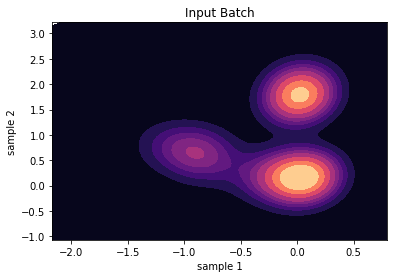

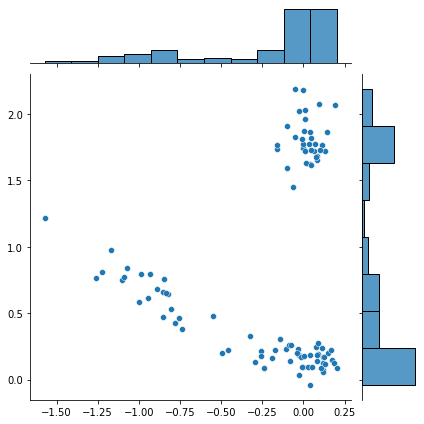

In [2]:

n =  2#@param {type: "number"}
d =  100 #@param {type: "number"}
num_clusters =  3 #@param {type: "number"}

distortion =   3 # how far clusters are from each other
dislocation = 10 # distortion of each cluster (from symmetricity) 

H0= gen_input(N=n,D=d, 
              num_clusters=num_clusters,
              distortion=distortion,
              dislocation=dislocation,)
H0 = H0 / 20

ax = sns.kdeplot(x=H0[0],y=H0[1],thresh=None,fill=True,cmap="magma")
ax.set_title('Input Batch')
ax.set_xlabel('sample 1')
ax.set_ylabel('sample 2')
ax = sns.jointplot(x=H0[0],y=H0[1])


# Compute Random MLP with residual connections

Layer weights $W_\ell\sim\mathcal{N}(0,1)^{d\times d}$, and $H_0 \in \mathbb{R}^{d\times n}$ denotes input batch

## Parameters
*  `r` (residual): $r\in[0,1]$: determins the strengith of residual connections:
$$H_{\ell+1}= (r) H_\ell + (1-r)\frac{1}{\sqrt{d}}W_\ell F\circ N(H_\ell)$$
*  `F` (activtion): one of the following
    * `Tanh`: $F(x)=\tanh(a x)$ 
    * `ReLU`: $F(x)=\max(x,0)$
    * `Linear`: $F(x)=x$
* `a`: used in $F(x)=\tanh(a x)$
* `Normalize` (Normlization): For $v\in \mathbb{R}^n$, it can be 
    * `Vanilla`: no normalization
    * `BN1` : unit-scale $$v\in \mathbb{R}^n: \qquad BN_1(v):= \frac{v}{\sqrt{\frac1n \sum_i^d v_i^2}}$$
    and for matrices it operates rowwise:
    $$H\in\mathbb{R}^{d\times n}:\qquad BN_1(H)=(BN_1(H_{i\cdot}))_{i\le d} $$
    * `BN2` : mean-reduction & unit-scale: $$v\in \mathbb{R}^n: \qquad BN_2(v) := BN_1(v - \frac1n v_i)$$ 
    and for matrices it operates rowwise:
    $$H\in\mathbb{R}^{d\times n}:\qquad BN_2(H)=(BN_2(H_{i\cdot}))_{i\le d} $$




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 16.77it/s]


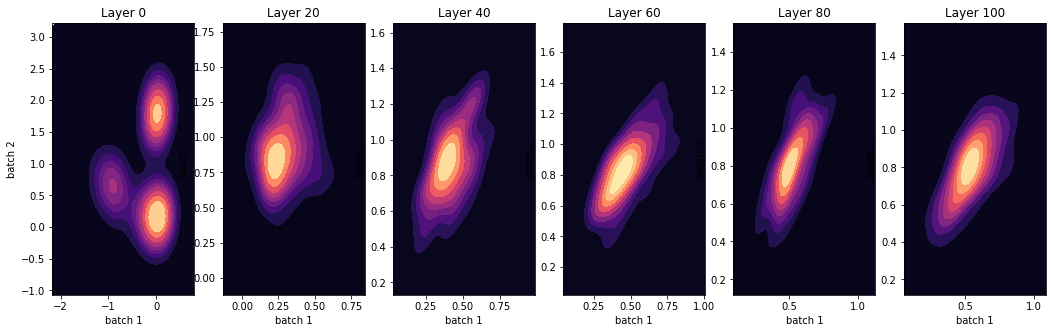

In [9]:
Normalize = 'BN1' #@param ['BN1','BN2', 'Vanilla']
F = 'ReLU' #@param ['ReLU', 'Linear','Tanh']
a =  .1#@param {type: "number"}
L =   100#@param {type: "number"}
residual = .9  #@param {type: "number"}


Normalizer, F = name2component(F,Normalize, a=a)
Layers = simulate(H0=H0,N=n, D=d, L=L+1, F=F, 
                      res=residual, 
                      Normalize=Normalizer)

#     fig = plt.figure()
#     for i in range(rows*cols):
#         ax = fig.add_subplot(rows, cols, i+1)
#         ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
#         ax.axis('off')
fig = plt.figure(figsize=(30,5))
cnt = 0
for layer in tqdm.trange(0,L+1,int((L+1)/5)):
    cnt += 1
    X = Layers[layer]
    ax = fig.add_subplot(1, 10, cnt)
    ax = sns.kdeplot(x=X[0],y=X[1],thresh=None,fill=True,cmap="magma")
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel('batch 1')
    ax.set_ylabel('batch 2')
    ax.grid(False)

plt.show()